# MPII数据集统计分析

In [1]:
import os
import cv2
import json
import random
import numpy as np
from pathlib import Path
from collections import defaultdict

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

# root = 'D:/Home/Storehouse/Dataset/mpii/'
root = '/Users/wucheng/仓库/Dataset/mpii/'

## 标注

In [2]:
with open(root + 'annot/mpii_annotations.json', 'r') as f:
    total_annots = json.load(f)

## 图片数与实例数(标注数)

**所有实例标注**

mpii_annotations.json - 25204

**拆分为训练集和验证集**

train.json - 22246

valid.json - 2958

In [3]:
train_annots, valid_annots = [], []
total_images, train_images, valid_images = set(), set(), set()
for ant in total_annots:
    total_images.add(ant['img_paths'])
    if not ant['isValidation']:
        train_annots.append(ant)
        train_images.add(ant['img_paths'])
    else:
        valid_annots.append(ant)
        valid_images.add(ant['img_paths'])
print(len(train_annots), len(valid_annots), len(total_annots))
print(len(train_images), len(valid_images), len(total_images))

22246 2958 25204
14679 2729 17408


In [29]:
valid_annots

list

## 标注格式

In [4]:
random.choice(total_annots)

{'dataset': 'MPI',
 'isValidation': 0.0,
 'img_paths': '080135206.jpg',
 'img_width': 1920.0,
 'img_height': 1080.0,
 'objpos': [691.0, 647.0],
 'joint_self': [[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [531.0, 866.0, 1.0],
  [702.0, 860.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [617.0, 863.0, 0.0],
  [671.0, 375.0, 1.0],
  [705.143, 318.095, 1.0],
  [843.857, 86.905, 1.0],
  [904.0, 745.0, 1.0],
  [634.0, 770.0, 1.0],
  [556.0, 392.0, 1.0],
  [786.0, 358.0, 1.0],
  [894.0, 566.0, 1.0],
  [1049.0, 702.0, 1.0]],
 'scale_provided': 8.088,
 'joint_others': {'_ArrayType_': 'double',
  '_ArraySize_': [0, 0],
  '_ArrayData_': None},
 'scale_provided_other': {'_ArrayType_': 'double',
  '_ArraySize_': [0, 0],
  '_ArrayData_': None},
 'objpos_other': {'_ArrayType_': 'double',
  '_ArraySize_': [0, 0],
  '_ArrayData_': None},
 'annolist_index': 8023.0,
 'people_index': 1.0,
 'numOtherPeople': 0.0}

## 标注可视化

### 标注按图片分组

In [7]:
image_annots = defaultdict(list)
for ant in total_annots:
    image_annots[ant['img_paths']].append(ant)
len(image_annots)

17408

### 绘制

可见点 - 红色

遮挡点 - 蓝色

In [5]:
def draw_annots(ants):
    img = Image.open(root + 'images/' + ants[0]['img_paths'])
    
    fig, ax = plt.subplots()
    ax.imshow(img)

    colors = ['g', 'deepskyblue', 'darkorange', 
             'orange', 'yellow', 'violet', 'palegreen', 
             'pink', 'aqua', 'springgreen', 'aquamarine', 'lightskyblue']
    skelenton = [[10, 11], [11, 12], [12, 8], [8, 13], 
                 [13, 14], [14, 15], [8, 9], [7, 8], [2, 6],
                 [3, 6], [1, 2], [1, 0], [3, 4], [4, 5],[6,7]]
    for ant in ants:
        joints = ant['joint_self']
        # 绘制骨骼
        color = random.choice(colors)
        for sk in skelenton:
            j1, j2 = joints[sk[0]], joints[sk[1]]
            if j1[0] > 0 and j1[1] > 0 and j2[0] > 0 and j2[1] > 0:
                ax.plot([j1[0], j2[0]], [j1[1], j2[1]], color=color)
        # 画关节点, 可见点-红色, 遮挡点-蓝色
        markersize = min(6, ant['scale_provided'] * 200. / min(ant['img_width'], ant['img_height']) * 6)
        for joint in joints:
            color = 'r' if joint[2] > 0.0 else 'b'
            if joint[0] > 0 and joint[1] > 0:
                ax.plot(joint[0], joint[1], marker='o', mfc=color, mec=color, markersize=markersize)
#     plt.axis('off')
    plt.show()
    
def draw_pose(img, joints, joints_vis):
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    skelenton = [[10, 11], [11, 12], [12, 8], [8, 13], 
                 [13, 14], [14, 15], [8, 9], [7, 8], [2, 6],
                 [3, 6], [1, 2], [1, 0], [3, 4], [4, 5],[6,7]]
    for sk in skelenton:
        j1, j2 = joints[sk[0]], joints[sk[1]]
        if j1[0] > 0 and j1[1] > 0 and j2[0] > 0 and j2[1] > 0:
            ax.plot([j1[0], j2[0]], [j1[1], j2[1]], color='violet')
    # 画关节点, 可见点-红色, 遮挡点-蓝色
    markersize = (np.min((np.max(joints, axis=0) - np.min(joints, axis=0)) / np.array(img.shape)[:2])) * 5 + 2
    for i, joint in enumerate(joints):
        color = 'r' if joints_vis[i] > 0.0 else 'b'
        if joint[0] > 0.0 and joint[1] > 0.0:
            ax.plot(joint[0], joint[1], marker='o', mfc=color, mec=color, markersize=markersize)
#     plt.axis('off')
    plt.show()

#### 绘制单个实例

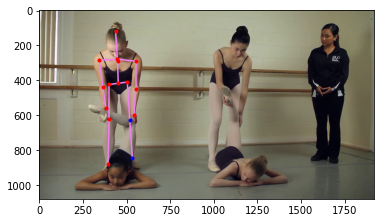

056831915.jpg


In [8]:
# img_path = random.choice(list(image_annots.keys()))
img_path = '056831915.jpg'
img = cv2.cvtColor(cv2.imread(root + 'images/' + img_path), cv2.COLOR_BGR2RGB)
joints = np.array(image_annots[img_path][0]['joint_self'])
draw_pose(img, joints[:, :2], joints[:, 2])
print(img_path)

#### 绘制图中所有实例

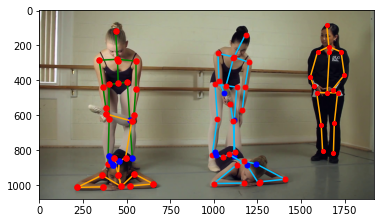

056831915.jpg


In [9]:
# img_path = random.choice(list(image_annots.keys()))
img_path = '056831915.jpg'

draw_annots(image_annots[img_path])
print(img_path)

## 选取一个小子集实验, 方便调试

``` python
sub_train_images = random.sample(train_images, 2000)
sub_train_annots = []
for img in sub_train_images:
    sub_train_annots += image_annots[img]

sub_valid_images = random.sample(valid_images, 400)
sub_valid_annots = []
for img in sub_valid_images:
    sub_valid_annots += image_annots[img]
    
print(len(sub_train_annots), len(sub_valid_annots))

sub_total_annots = sub_train_annots + sub_valid_annots
with open('/Users/wucheng/仓库/Dataset/mpii/annot/mini_mpii.json', 'w') as f:
    json.dump(sub_total_annots, f)
```

## 数据预处理

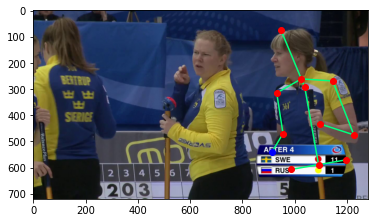

{'dataset': 'MPI',
 'isValidation': 0.0,
 'img_paths': '015599452.jpg',
 'img_width': 1280.0,
 'img_height': 720.0,
 'objpos': [1010.0, 412.0],
 'joint_self': [[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [987.0, 607.0, 1.0],
  [1194.0, 571.0, 1.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [1091.0, 589.0, 1.0],
  [1038.0, 292.0, 1.0],
  [1025.0, 261.0, 1.0],
  [947.0, 74.0, 1.0],
  [914.0, 539.0, 0.0],
  [955.0, 470.0, 1.0],
  [931.0, 315.0, 1.0],
  [1145.0, 269.0, 1.0],
  [1226.0, 475.0, 1.0],
  [1096.0, 433.0, 1.0]],
 'scale_provided': 6.071,
 'joint_others': [[[0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0],
   [806.0, 543.0, 1.0],
   [720.0, 593.0, 1.0],
   [0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0],
   [763.0, 568.0, 1.0],
   [683.0, 290.0, 0.0],
   [682.0, 256.0, 1.0],
   [676.0, 68.0, 1.0],
   [563.0, 296.0, 1.0],
   [555.0, 410.0, 1.0],
   [647.0, 281.0, 0.0],
   [719.0, 299.0, 1.0],
   [711.0, 516.0, 1.0],
   [545.0, 466.0, 1.0]],
  [[0.0, 0.0, 0.0],
   [0.0, 0.0, 0.0],
   [228.0, 537.0, 1.0],
   [74.0,

In [10]:
### 配置参数
inp_res = 256
oup_res = 64
scale_factor, rot_factor = 0.25, 30
transform = None

sigma = 2

# ant = random.choice(train_annots)
# ant = random.choice(valid_annots)
ant = train_annots[3]
draw_annots([ant])
ant

In [15]:
# 获取旋转后的坐标
def get_dir(src, rot_rad):
    sin, cos = np.sin(rot_rad), np.cos(rot_rad)
    return [src[0] * cos - src[1] * sin, src[0] * sin + src[1] * cos]

# 获取仿射变换
def get_affine_transform(center, bw, bh, rot, dst_w, dst_h, inverse=False):
        # 三个点构建仿射变换实现 旋转、裁剪
        src, dst = np.zeros((3, 2), dtype=np.float32), np.zeros((3, 2), dtype=np.float32)
        src[0, :] = center
        src[1, :] = center + get_dir([0, bh * -0.5], np.pi * rot / 180)
        src[2, :] = center + get_dir([bw * -0.5, bh * -0.5], np.pi * rot / 180)
        # center仿射变换后 即 新图片的中心 [w / 2, h / 2] 
        dst[0, :] = np.array([dst_w * 0.5, dst_h * 0.5])
        dst[1, :] = np.array([dst_w * 0.5, 0])
        dst[2, :] = np.array([0, 0])

        if inverse:
            affine_trans = cv2.getAffineTransform(np.float32(dst), np.float32(src))
        else:
            affine_trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))
        return affine_trans
    
# 应用仿射变换
def affine_transform(joints, t):
    new_joints = np.array([joints[0], joints[1], 1.]).T
    new_joints = np.dot(t, new_joints)
    return new_joints[:2]

# 对图像和关节点同时应用变换
def perform_transform(img, joints, trans, dst_w, dst_h):
    input = cv2.warpAffine(img, trans, (int(dst_w), int(dst_h)), flags=cv2.INTER_LINEAR)
    # 坐标真值随仿射变换修改
    for i in range(joints.shape[0]):
        joints[i] = affine_transform(joints[i], trans)
    return input, joints

# 获取欧式变换
def get_similarity_transform(center, rot, tx, ty):
    trans = cv2.getRotationMatrix2D(center, rot, 1)
    trans[0, 2] += tx
    trans[1, 2] += ty
    return trans

# 复合变换
def mul_transform(t1, t2):
    t1 = np.concatenate([t1, np.array([[0, 0, 1]])], axis=0)
    t2 = np.concatenate([t2, np.array([[0, 0, 1]])], axis=0)
    return np.dot(t1, t2)[:2, :]

# 生成高斯概率热图
def generate_target(joints, joints_vis, sigma, image_size, heatmap_size):
    num_joints = joints.shape[0]
    target_weight = joints_vis.copy()

    target = np.zeros((num_joints,
                       heatmap_size,
                       heatmap_size),
                      dtype=np.float32)

    for joint_id in range(num_joints):
        feat_stride = image_size / heatmap_size
        mu_x = int(joints[joint_id][0] / feat_stride + 0.5)
        mu_y = int(joints[joint_id][1] / feat_stride + 0.5)
        # 以3 * sigma为阈值，关节点坐标与图片尺寸差距超过阈值，被认为位于图像之外，视为不可见
        ul = [int(mu_x - 3 * sigma), int(mu_y - 3 * sigma)]
        br = [int(mu_x + 3 * sigma + 1), int(mu_y + 3 * sigma + 1)]
        if ul[0] >= heatmap_size or ul[1] >= heatmap_size \
                or br[0] < 0 or br[1] < 0:
            target_weight[joint_id] = 0
            continue

        # 生成高斯概率
        size = 6 * sigma + 1
        x = np.arange(0, size, 1, np.float32)
        y = x[:, np.newaxis]
        x0 = y0 = size // 2
        # The gaussian is not normalized, we want the center value to equal 1
        g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

        # Usable gaussian range
        g_x = max(0, -ul[0]), min(br[0], heatmap_size) - ul[0]
        g_y = max(0, -ul[1]), min(br[1], heatmap_size) - ul[1]
        # Image range
        img_x = max(0, ul[0]), min(br[0], heatmap_size)
        img_y = max(0, ul[1]), min(br[1], heatmap_size)

#         v = target_weight[joint_id]
#         if v > 0.5:
        target[joint_id][img_y[0]:img_y[1], img_x[0]:img_x[1]] = \
            g[g_y[0]:g_y[1], g_x[0]:g_x[1]]

    return target, target_weight

### 正常处理

In [16]:
def preprocess_scale(ant, use_augment=False):
    img_path = os.path.join(root , 'images', Path(ant['img_paths']).name)
    joints = np.array(ant['joint_self'])
    joints_p, joints_vis = joints[:, 0:2].copy(), joints[:, 2].copy()

    # center为实例框中心坐标, scale为缩放幅度, scale*200即实例框的宽和高, 注: 一个正方形大致圈出实例范围, 不是准确的检测框
    center, scale = np.array(ant['objpos']), ant['scale_provided']

    # 稍微增大实例框, 防止实例截断
    if center[0] != -1:
        center[1] = center[1] + 15 * scale
        scale = scale * 1.25

    # 读取图片
    num_joints = 16
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    # 训练增强
    rot = 0
    if use_augment:
        # 放缩
        scale = scale * np.clip(np.random.randn() * scale_factor + 1, 1 - scale_factor, 1 + scale_factor)
        # 旋转
        rot = np.clip(np.random.randn() * rot_factor, -2 * rot_factor, 2 * rot_factor) if random.random() <= 0.6 else 0
    
    # 使用仿射变换实现放缩、平移和旋转
    trans = get_affine_transform(center, scale * 200.0, scale * 200, rot, inp_res, inp_res, inverse=False)
    input = cv2.warpAffine(img, trans, (inp_res, inp_res), flags=cv2.INTER_LINEAR)

    # 坐标真值随仿射变换修改
    for i in range(num_joints):
        joints_p[i] = affine_transform(joints_p[i], trans)

    target, target_weight = generate_target(joints_p, joints_vis, sigma, inp_res, oup_res)
    draw_pose(input, joints_p, joints_vis)
    
    return input, joints_p, target, target_weight

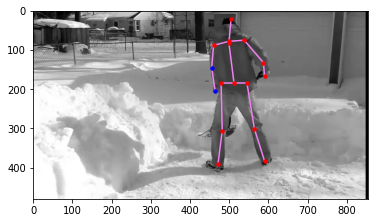

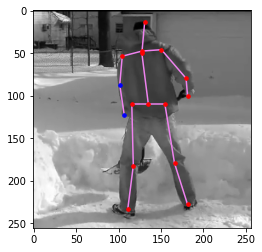

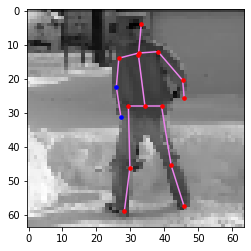

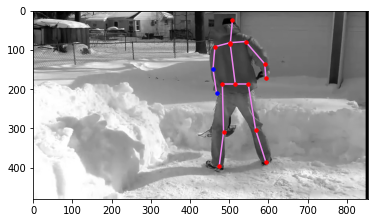

In [17]:
ant = total_annots[999]
img_path = os.path.join(root , 'images', Path(ant['img_paths']).name)
joints = np.array(ant['joint_self'])
joints_p, joints_vis = joints[:, 0:2].copy(), joints[:, 2].copy()

# center为实例框中心坐标, scale为缩放幅度, scale*200即实例框的宽和高, 注: 一个正方形大致圈出实例范围, 不是准确的检测框
center, scale = np.array(ant['objpos']), ant['scale_provided']

# 稍微增大实例框, 防止实例截断
if center[0] != -1:
    center[1] = center[1] + 15 * scale
    scale = scale * 1.25

# 读取图片
num_joints = 16
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
draw_pose(img, joints_p, joints_vis)
# 训练增强
rot = 0

# 使用仿射变换实现放缩、平移和旋转
trans = get_affine_transform(center, scale * 200.0, scale * 200, rot, inp_res, inp_res, inverse=False)
input = cv2.warpAffine(img, trans, (inp_res, inp_res), flags=cv2.INTER_LINEAR)

# 坐标真值随仿射变换修改
for i in range(num_joints):
    joints_p[i] = affine_transform(joints_p[i], trans)

draw_pose(input, joints_p, joints_vis)

target, target_weight = generate_target(joints_p, joints_vis, sigma, inp_res, oup_res)
img2 = cv2.resize(input, (64, 64))
joints_m = np.zeros((16, 2))
for i in range(16):
    joints_m[i] = joints_p[i] / 4 + 0.5
draw_pose(img2, joints_m, target_weight)


# 使用仿射变换实现放缩、平移和旋转
trans = get_affine_transform(center, scale * 200.0, scale * 200, rot, 64, 64, inverse=True)

# 坐标真值随仿射变换修改
for i in range(num_joints):
    joints_p[i] = affine_transform(joints_m[i], trans)
draw_pose(img, joints_p, joints_vis)

### scale不准

**使用关节点横纵坐标和center距离的最大最小值修正scale**

In [45]:
np.ones((2, 2, 3), dtype=np.int32)

array([[[1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1]]], dtype=int32)

In [18]:
def preprocess_joint(ant, use_augment=False):
    # ant = random.choice(train_annots)
    img_path = os.path.join(root , 'images', Path(ant['img_paths']).name)
    joints = np.array(ant['joint_self'])
    joints_p, joints_vis = joints[:, 0:2].copy(), joints[:, 2].copy()

    # 读取图片
    num_joints = 16
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    # center为实例框中心坐标, scale为缩放幅度, scale*200即实例框的宽和高, 注: 一个正方形大致圈出实例范围, 不是准确的检测框
    center, scale = np.array(ant['objpos']), ant['scale_provided']
    
    # 增大实例框, 防止实例截断
    center[1] = center[1] + 15 * scale
    scale = scale * 1.25 * 200.0

    # 数据集提供的scale不准, 常出现偏大的情况, 使用center + joints重新修正scale
    w = np.extract(np.logical_or(joints_vis > 0, joints_p[:, 0] > 0), joints_p[:, 0])
    h = np.extract(np.logical_or(joints_vis > 0, joints_p[:, 1] > 0), joints_p[:, 1])
    l, r, u, b = min(w), max(w), min(h), max(h)
    scale_refine = max(center[0] - l, r - center[0], center[1] - u, b - center[1]) * 2 + 10
    
    # 遮挡点坐标有时候会出现标注错误的情况, 错误标注作为离群点使得scale_refine过大, 设置当scale_refine过大-超过原scale的1.5倍, 则放弃修正
    if scale_refine >= 1.5 * scale:
        scale_refine = scale
    
    
    # 关节点只是手腕、脚踝这些部位，
    # 虽然能保证关节点都截进来，但是手、脚有一部分在图像外，关节点定位需要手、脚的信息,所以稍微增大scale_refine
    # scale不准，所以scale至少要为scale_refine才能保证所有关节点都截进来
    scale = min(max(scale, scale_refine), scale_refine * 1.25)
    
    # 训练增强
    rot = 0
    if use_augment:
        # 放缩
        scale = scale * np.clip(np.random.randn() * scale_factor + 1, 1, 1.25)
        # 旋转
        rot = np.clip(np.random.randn() * rot_factor, -2 * rot_factor, 2 * rot_factor) if random.random() <= 0.6 else 0

    # 使用仿射变换实现放缩、平移和旋转
    trans = get_affine_transform(center, scale, scale, rot, inp_res, inp_res, inverse=False)
    input = cv2.warpAffine(img, trans, (inp_res, inp_res), flags=cv2.INTER_LINEAR)

    # 坐标真值随仿射变换修改
    for i in range(num_joints):
        joints_p[i] = affine_transform(joints_p[i], trans)

    target, target_weight = generate_target(joints_p, joints_vis, sigma, inp_res, oup_res)
    draw_pose(input, joints_p, joints_vis)
    
    return input, joints_p, target, target_weight

#### scale修正效果

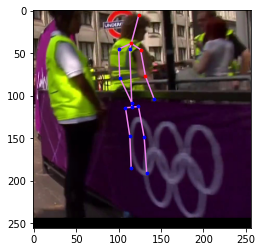

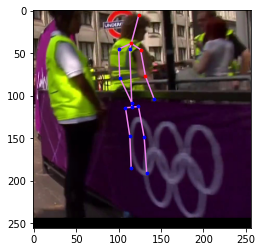

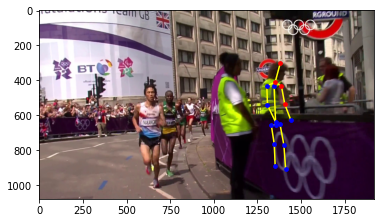

In [20]:
ant = random.choice(train_annots)
# ant = image_annots['003467270.jpg'][0]
# ant = random.choice(valid_annots)
preprocess_scale(ant, False)
preprocess_joint(ant, False)
draw_annots([ant])

### scale是正方形，不是真实的人体检测框, 经常框到其他实例

In [21]:
def preprocess_box(ant, use_augment=False):
    # ant = random.choice(train_annots)
    img_path = os.path.join(root , 'images', Path(ant['img_paths']).name)
    joints = np.array(ant['joint_self'])
    joints_p, joints_vis = joints[:, 0:2].copy(), joints[:, 2].copy()

    # 读取图片
    num_joints = 16
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    # 数据集提供的scale不准, 常出现偏大的情况, 使用center + joints重新修正scale
    w = np.extract(np.logical_or(joints_vis > 0, joints_p[:, 0] > 0), joints_p[:, 0])
    h = np.extract(np.logical_or(joints_vis > 0, joints_p[:, 1] > 0), joints_p[:, 1])
    l, r, u, b = min(w), max(w), min(h), max(h)
    box_width, box_height = (r - l + 10) * 1.25, (b - u + 10) * 1.25
    
    # 训练增强
    rot = 0
    if use_augment:
        # 旋转
        rot = np.clip(np.random.randn() * rot_factor, -2 * rot_factor, 2 * rot_factor) if random.random() <= 0.6 else 0
    
    # 使用仿射变换实现放缩、平移和旋转
    trans = get_affine_transform(np.array([(r + l) // 2, (b + u) // 2]), box_width, box_height, rot, inp_res, inp_res, inverse=False)
    input = cv2.warpAffine(img, trans, (inp_res, inp_res), flags=cv2.INTER_LINEAR)

    # 坐标真值随仿射变换修改
    for i in range(num_joints):
        joints_p[i] = affine_transform(joints_p[i], trans)

    target, target_weight = generate_target(joints_p, joints_vis, sigma, inp_res, oup_res)
    draw_pose(input, joints_p, joints_vis)
#     draw_pose(img, joints[:, :2], joints_vis)
    
    return input, joints_p, target, target_weight

### 直接裁剪box在resize导致形变

**裁剪 resize 加 padding**

In [22]:
def preprocess_ratio(ant, use_augment=False):
    img_path = os.path.join(root , 'images', Path(ant['img_paths']).name)
    joints = np.array(ant['joint_self'])
    joints_p, joints_vis = joints[:, 0:2].copy(), joints[:, 2].copy()

    # 读取图片
    num_joints = 16
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    # 数据集提供的scale不准, 常出现偏大的情况, 使用center + joints重新修正scale
    w = np.extract(np.logical_or(joints_vis > 0, joints_p[:, 0] > 0), joints_p[:, 0])
    h = np.extract(np.logical_or(joints_vis > 0, joints_p[:, 1] > 0), joints_p[:, 1])
    l, r, u, b = min(w), max(w), min(h), max(h)
    box_width, box_height = min((r - l + 10) * 1.25, img.shape[1]), min((b - u + 10) * 1.25, img.shape[0])
    
    # resize保持比例
    as_ratio = min(inp_res / box_height, inp_res / box_width)
    new_w, new_h = int(as_ratio * box_width), int(as_ratio * box_height)
    
    # 训练增强
    rot = 0
    if use_augment:
        # 旋转
        rot = np.clip(np.random.randn() * rot_factor, -2 * rot_factor, 2 * rot_factor) if random.random() <= 0.6 else 0
        
    # 使用仿射变换实现放缩、平移和旋转
    trans = get_affine_transform(np.array([(r + l) // 2, (b + u) // 2]), box_width, box_height, rot, new_w, new_h, inverse=False)
    input = cv2.warpAffine(img, trans, (new_w, new_h), flags=cv2.INTER_LINEAR)

    # 坐标真值随仿射变换修改
    for i in range(num_joints):
        joints_p[i] = affine_transform(joints_p[i], trans)
    
    # padding
    pw, ph = inp_res - new_w, inp_res - new_h
    pl, pr, pu, pb = pw // 2, pw - pw // 2, ph // 2, ph - ph // 2
    input = cv2.copyMakeBorder(input, pu, pb, pl, pr, cv2.BORDER_CONSTANT,None,(0,0,0))
    joints_p += [pl, pu]
    
    target, target_weight = generate_target(joints_p, joints_vis, sigma, inp_res, oup_res)
    draw_pose(input, joints_p, joints_vis)
    draw_pose(img, joints[:, :2], joints_vis)
    
    return input, joints_p, target, target_weight

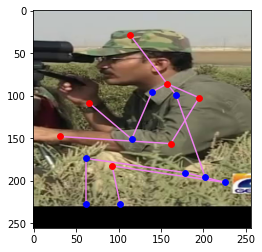

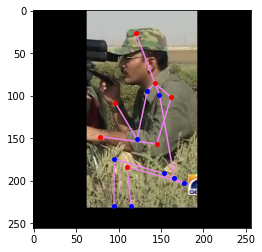

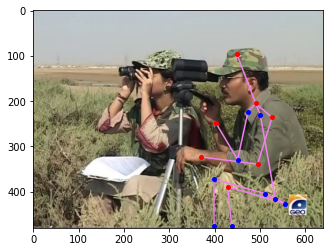

022996142.jpg


In [23]:
ant = random.choice(train_annots)
# ant = image_annots['071711949.jpg'][0]
# ant = random.choice(valid_annots)
# preprocess_scale(ant)
# preprocess_joint(ant)
preprocess_box(ant, False)
preprocess_ratio(ant, False)
print(ant['img_paths'])

### 训练增强导致关节点跑出图外

**使用欧式变换实现旋转, 重新计算旋转后的图像尺寸以保持图像不被截断**

In [24]:
def preprocess_augment(ant, use_augment=False):
    img_path = os.path.join(root , 'images', Path(ant['img_paths']).name)
    joints = np.array(ant['joint_self'])
    joints_p, joints_vis = joints[:, 0:2].copy(), joints[:, 2].copy()

    # 读取图片
    num_joints = 16
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    # 数据集提供的scale不准, 常出现偏大的情况, 使用center + joints重新修正scale
    w = np.extract(np.logical_or(joints_vis > 0, joints_p[:, 0] > 0), joints_p[:, 0])
    h = np.extract(np.logical_or(joints_vis > 0, joints_p[:, 1] > 0), joints_p[:, 1])
    l, r, u, b = min(w), max(w), min(h), max(h)
    box_width, box_height = min(int((r - l + 30) * 1.25), img.shape[1]), min(int((b - u + 30) * 1.25), img.shape[0])
    
    rot = 0
    if use_augment:
        sf = np.clip(1 + np.random.randn() * 0.25, 0.8, 1 + 0.25)
        box_width, box_height = box_width * sf, box_height * sf
        
        rot = np.clip(np.random.randn() * rot_factor, -2 * rot_factor, 2 * rot_factor) if random.random() <= 0.6 else 0

    # 放缩保持比例
    as_ratio = min(inp_res / box_height, inp_res / box_width)
    new_w, new_h = int(as_ratio * box_width), int(as_ratio * box_height)
    
    # 使用仿射变换实现裁剪 + 放缩
    trans = get_affine_transform(np.array([(r + l) // 2, (b + u) // 2]), box_width, box_height, 0, new_w, new_h, inverse=False)
    
    # 应用变换
    input, joints_p = perform_transform(img, joints_p, trans, new_w, new_h)
    
    # 训练增强-旋转
    if rot != 0:        
        # 使用相似变换-(平移+放缩+旋转)
        rot_w = int(new_h * np.fabs(np.sin(np.radians(rot))) + new_w * np.fabs(np.cos(np.radians(rot))))
        rot_h = int(new_w * np.fabs(np.sin(np.radians(rot))) + new_h * np.fabs(np.cos(np.radians(rot))))
        
        augment_trans = get_similarity_transform((new_w // 2, new_h // 2), rot, (rot_w - new_w) // 2, (rot_h - new_h) // 2)

        # 旋转后为保持原图不被裁剪放大了图像尺寸, 重新保持比例放缩到指定尺寸
        as_ratio = min(inp_res / rot_w, inp_res / rot_h)
        new_w, new_h = int(as_ratio * rot_w), int(as_ratio * rot_h)
        # 再次使用仿射变换裁剪
        crop_trans = get_affine_transform(np.array([rot_w // 2, rot_h // 2]), rot_w, rot_h, 0, new_w, new_h, inverse=False)
        
        # 复合变换
        trans = mul_transform(crop_trans, augment_trans)
        input, joints_p = perform_transform(input, joints_p, trans, new_w, new_h)
        
    # padding
    pw, ph = inp_res - new_w, inp_res - new_h
    pl, pr, pu, pb = pw // 2, pw - pw // 2, ph // 2, ph - ph // 2
    input = cv2.copyMakeBorder(input, pu, pb, pl, pr, cv2.BORDER_CONSTANT,None,(0,0,0))
    joints_p += [pl, pu]
    
    target, target_weight = generate_target(joints_p, joints_vis, sigma, inp_res, oup_res)
    draw_pose(input, joints_p, joints_vis)
    draw_pose(img, joints[:, :2], joints_vis)
    
    return input, joints_p, target, target_weight

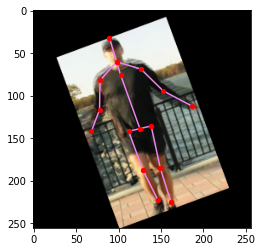

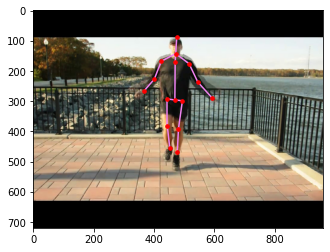

In [45]:
ant = random.choice(train_annots)
# ant = random.choice(valid_annots)
_ = preprocess_augment(ant, True)

### 增加flip训练增强

In [46]:
# 水平翻转
def flip_joints(joints, joints_vis, img_width, dataset='mpii'):
    flip_pairs =  [[0, 5], [1, 4], [2, 3], [10, 15], [11, 14], [12, 13]]
    if dataset.lower() == 'mpii':
        flip_pairs =  [[0, 5], [1, 4], [2, 3], [10, 15], [11, 14], [12, 13]]
    joints[:, 0] = img_width - joints[:, 0] - 1
    
    for a, b in flip_pairs:
        joints[a, :], joints[b, :] = joints[b, :], joints[a, :].copy()
        joints_vis[a], joints_vis[b] = joints_vis[b], joints_vis[a]
    return joints, joints_vis

In [48]:
def preprocess_flip(ant, use_augment=False):
    img_path = os.path.join(root , 'images', Path(ant['img_paths']).name)
    joints = np.array(ant['joint_self'])
    joints_p, joints_vis = joints[:, 0:2].copy(), joints[:, 2].copy()

    # 读取图片
    num_joints = 16
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    # 数据集提供的scale不准, 常出现偏大的情况, 使用center + joints重新修正scale
    w = np.extract(np.logical_or(joints_vis > 0, joints_p[:, 0] > 0), joints_p[:, 0])
    h = np.extract(np.logical_or(joints_vis > 0, joints_p[:, 1] > 0), joints_p[:, 1])
    l, r, u, b = min(w), max(w), min(h), max(h)
    box_width, box_height = min(int((r - l + 30) * 1.25), img.shape[1]), min(int((b - u + 30) * 1.25), img.shape[0])
    
    rot, flip = 0, False
    if use_augment:
        sf = np.clip(1 + np.random.randn() * 0.25, 0.8, 1 + 0.25)
        box_width, box_height = box_width * sf, box_height * sf
        
        rot = np.clip(np.random.randn() * rot_factor, -2 * rot_factor, 2 * rot_factor) if random.random() <= 0.6 else 0
        
        flip = np.random.rand() >= 0.5
        
    # 放缩保持比例
    as_ratio = min(inp_res / box_height, inp_res / box_width)
    new_w, new_h = int(as_ratio * box_width), int(as_ratio * box_height)
    
    # 使用仿射变换实现裁剪 + 放缩
    trans = get_affine_transform(np.array([(r + l) // 2, (b + u) // 2]), box_width, box_height, 0, new_w, new_h, inverse=False)
    
    # 应用变换
    input, joints_p = perform_transform(img, joints_p, trans, new_w, new_h)
    
    # 训练增强-旋转
    if rot != 0:        
        # 使用相似变换-(平移+放缩+旋转)
        rot_w = int(new_h * np.fabs(np.sin(np.radians(rot))) + new_w * np.fabs(np.cos(np.radians(rot))))
        rot_h = int(new_w * np.fabs(np.sin(np.radians(rot))) + new_h * np.fabs(np.cos(np.radians(rot))))
        
        augment_trans = get_similarity_transform((new_w // 2, new_h // 2), rot, (rot_w - new_w) // 2, (rot_h - new_h) // 2)

        # 旋转后为保持原图不被裁剪放大了图像尺寸, 重新保持比例放缩到指定尺寸
        as_ratio = min(inp_res / rot_w, inp_res / rot_h)
        new_w, new_h = int(as_ratio * rot_w), int(as_ratio * rot_h)
        # 再次使用仿射变换裁剪
        crop_trans = get_affine_transform(np.array([rot_w // 2, rot_h // 2]), rot_w, rot_h, 0, new_w, new_h, inverse=False)
        
        # 复合变换
        trans = mul_transform(crop_trans, augment_trans)
        input, joints_p = perform_transform(input, joints_p, trans, new_w, new_h)
    
    # padding
    pw, ph = inp_res - new_w, inp_res - new_h
    pl, pr, pu, pb = pw // 2, pw - pw // 2, ph // 2, ph - ph // 2
    input = cv2.copyMakeBorder(input, pu, pb, pl, pr, cv2.BORDER_CONSTANT,None,(0,0,0))
    joints_p += [pl, pu]
    
    # 训练增强-水平翻转
    if flip:
        input = input[:, ::-1, :]
        joints_p, joints_vis = flip_joints(joints_p, joints_vis, inp_res, dataset='mpii')
     
    target, target_weight = generate_target(joints_p, joints_vis, sigma, inp_res, oup_res)
    draw_pose(input, joints_p, joints_vis)
    draw_pose(img, joints[:, :2], joints_vis)
    
    return input, joints_p, target, target_weight

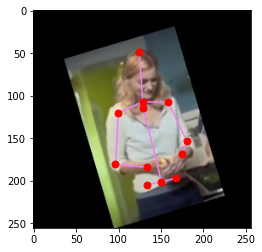

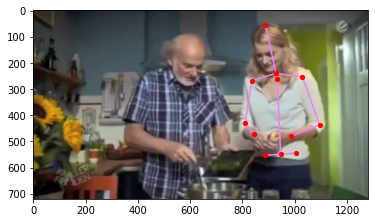

022367560.jpg


In [54]:
ant = random.choice(train_annots)
# ant = random.choice(valid_annots)
# ant = image_annots['005183580.jpg'][0]

_ = preprocess_flip(ant, True)
print(ant['img_paths'])

### 高斯热图生成验证

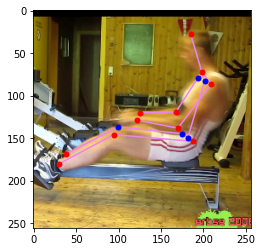

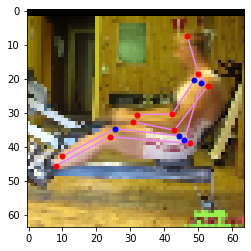

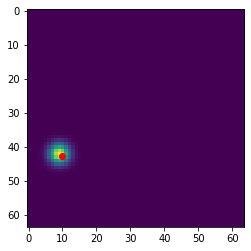

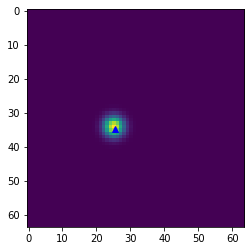

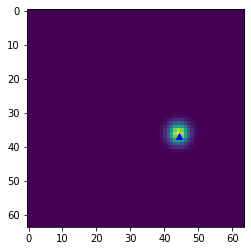

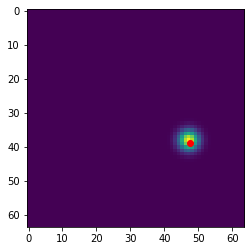

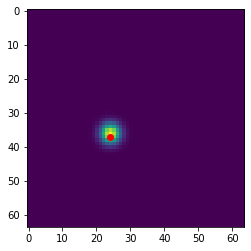

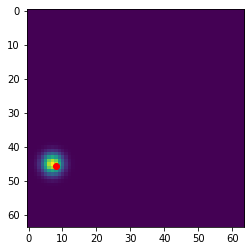

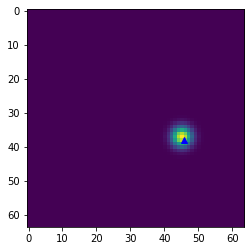

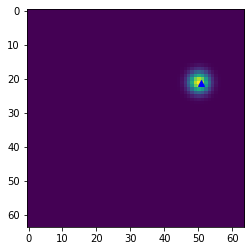

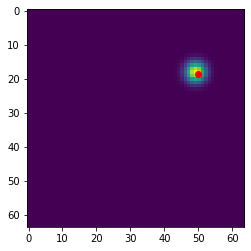

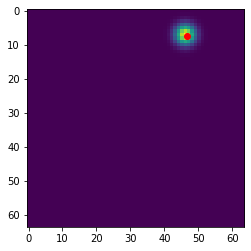

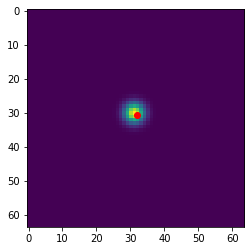

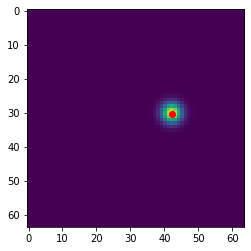

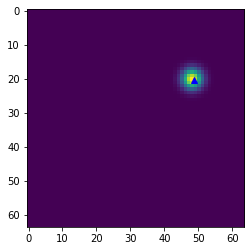

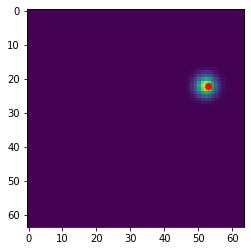

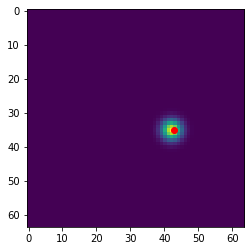

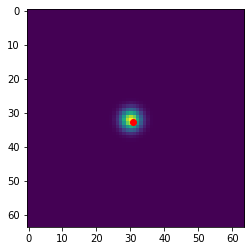

In [25]:
ant = random.choice(train_annots)
# ant = image_annots['066144084.jpg'][1]
# ant = random.choice(valid_annots)

input, joints_p, target, target_weight = preprocess_joint(ant)

img = cv2.resize(input, (64, 64))
joints_m = np.zeros((16, 2))
for i in range(16):
    joints_m[i] = joints_p[i] / 4 + 0.5
draw_pose(img, joints_m, target_weight)
for i in range(target.shape[0]):
#     if target_weight[i] > 0:
    plt.imshow(target[i])
    if target_weight[i] > 0:
        plt.plot(joints_m[i][0], joints_m[i][1], marker='o', color='r')
    else:
        plt.plot(joints_m[i][0], joints_m[i][1], marker='^', color='b')
    plt.show()

## 带遮挡的实例

**解决多人姿态估计任务自顶向下方式中第二阶段的遮挡点估计改善问题, 本质上还是单人姿态估计问题, 所以应以每个实例作为单个样本**

### 标注的关节点
0. 右脚踝 
1. 右膝盖
2. 右臀部
3. 左臀部
4. 左膝盖
5. 左脚踝
6. 骨盆
7. 胸部
8. 颈部
9. 头部
10. 右手腕
11. 右手肘
12. 右肩
13. 左肩
14. 左手肘
15. 左手腕

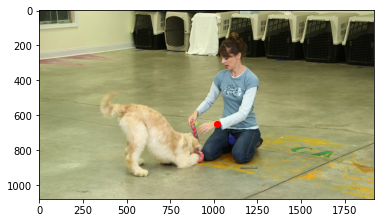

In [246]:
img_path = '063058870.jpg'
img = cv2.cvtColor(cv2.imread(root + 'images/' + img_path), cv2.COLOR_BGR2RGB)
joints = np.array(image_annots[img_path][0]['joint_self'])

plt.imshow(img)

j = 15
plt.plot(joints[j][0], joints[j][1], marker='o', mfc='r', mec='r')

plt.show()

In [59]:
joint_names = ['right_ankle', 'right_knee', 'right_hip', 
              'left_hip', 'left_knee', 'left_ankle', 
              'pelvis', 'thorax', 'upper_neck', 'head_top', 
              'right_wrist', 'right_elbow', 'right_shoulder', 
              'left_shoulder', 'left_elbow', 'left_wrist']

In [60]:
joint_names_dict = {i: name for i, name in enumerate(joint_names)}

### 统计样本(实例)遮挡信息

该实例的是否有关节点被遮挡, 遮挡的关节点有几个, 是哪些关节点被遮挡了

In [61]:
annots_with_occinfo = []
for ant in total_annots:
    d = {'has_occluded': False, 
         'num_occluded': 0, 
         'occluded_joints': [],
         'occluded_joints_name': [], 
         'image': ant['img_paths'], 
         'annot': ant}
    for i, x in enumerate(ant['joint_self']):
        # 被遮挡
        if x[2] < 1.0:
            d['num_occluded'] += 1
            d['occluded_joints'].append(i)
            d['occluded_joints_name'].append(joint_names_dict[i])
    d['has_occluded'] = d['num_occluded'] > 0
    annots_with_occinfo.append(d)

In [62]:
len(annots_with_occinfo)

25204

### 带遮挡关节点的样本(实例)

In [63]:
annots_occ = []
for ant in annots_with_occinfo:
    if ant['has_occluded']:
        annots_occ.append(ant)
len(annots_occ)

21920

总共有25204个实例, 其中只有3284个实例是完全无遮挡, 剩下21920个实例都存在部分遮挡

### 统计各关节点的被遮挡情况

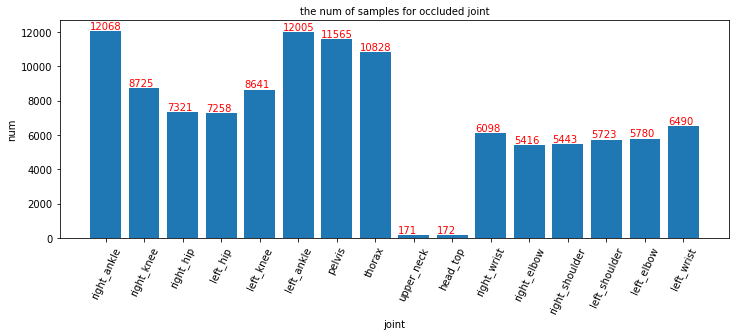

In [64]:
joints_occ_num = [0] * 16
for ant in annots_occ:
    for j in ant['occluded_joints']:
        joints_occ_num[j] += 1

fig, ax = plt.subplots(figsize=(12.0, 4.))
rects = ax.bar(range(16), joints_occ_num)
for rect in rects:
    ax.text(rect.get_x(), rect.get_height(), rect.get_height(), ha='left', va='bottom', color='red')

plt.xticks(range(16), joint_names, rotation=65)

plt.title('the num of samples for occluded joint', fontsize=10)
plt.xlabel('joint', fontsize=10)
plt.ylabel('num')
plt.show()

头部和颈部几乎没有遮挡

### 带遮挡的图片总数

In [65]:
images_occ = set()
for ant in annots_occ:
    images_occ.add(ant['image'])
len(images_occ)

15753

In [6]:
import torch

In [11]:
a = torch.tensor([[1, 2, 3, 4]])

In [13]:
a.eq(1)

tensor([[ True, False, False, False]])

In [19]:
torch.pow(a.eq(1), 4)

tensor([[1, 0, 0, 0]])